In [185]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

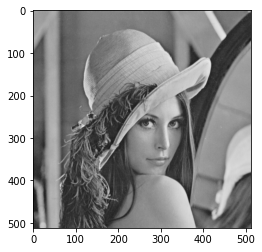

In [186]:
lena = cv2.imread('lena.bmp')
plt.imshow(lena)

True

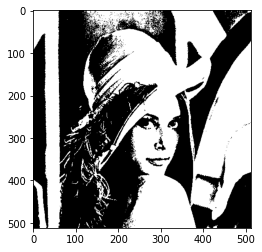

In [187]:
def binarize(lena, thr=128):
    after = copy.deepcopy(lena)
    for r in range(after.shape[0]):
        for c in range(after.shape[1]):
            if (np.sum(after[r][c]) < thr*3) : after[r][c] = [0,0,0]
            else: after[r][c] = [255,255,255]
    return after
bina = binarize(lena)
plt.imshow(bina)
cv2.imwrite('binarize lena.bmp',bina)
cv2.imwrite('binarize lena.png',bina)


In [188]:
def get_historgram(lena):
    hist = np.zeros(256)
    for r in range(lena.shape[0]):
        for c in range(lena.shape[1]):
            hist[lena[r][c]] += 1
    return hist

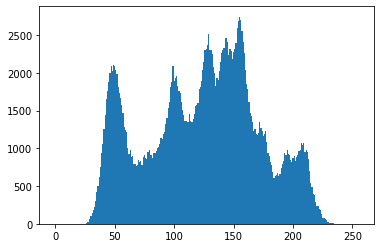

In [189]:
hist = get_historgram(lena)
plt.bar([i for i in range(256)], hist, width=1)
plt.savefig("histogram.png")

In [190]:
import numpy as np
class UnionFindSet2D():
    def __init__(self, h, w):
        self.parents = np.arange(h*w)
        self.ranks = np.zeros(h*w)
        self.height = h
        self.width = w

    def find_by_idx (self, idx):
        while (idx != self.parents[idx]):
            self.parents[idx] = self.parents[self.parents[idx]]
            idx = self.parents[idx]
        return self.parents[idx]
    
    def union (self, ca, cb):
        ia = ca[0] * self.width + ca[1]
        ib = cb[0] * self.width + cb[1]

        parent_a = self.find_by_idx(ia)
        parent_b = self.find_by_idx(ib)

        if (self.ranks[parent_a] > self.ranks[parent_b]):
            self.parents[parent_b] = parent_a
        elif (self.ranks[parent_a] < self.ranks[parent_b]):
            self.parents[parent_a] = parent_b
        else:
            self.parents[parent_b] = parent_a
            self.ranks[parent_a] += 1


In [191]:
def FindSet(bina):
    height, width, _ = bina.shape

    ufs = UnionFindSet2D(height, width)
    four_dir = [
        np.array([-1, 0]),  # up
        np.array([1, 0]),  # down
        np.array([0, -1]),  # left
        np.array([0, 1]),  # right
    ]

    def is_outbound(coord, height, width):
        return (coord[0] < 0 or coord[1] < 0 or 
                coord[0] >= height or coord[1] >= width)

    for r in range(height):
        for c in range(width):
            if (bina[r][c][0] != 255): # Not White
                continue

            cur = np.array([r, c])
            for d in four_dir:
                tmp = copy.deepcopy(cur) + d

                if (is_outbound(tmp, height, width)):
                    continue
                elif (bina[tmp[0]][tmp[1]][0] == 255): # is white?
                    ufs.union(cur, tmp)
    
    return ufs


In [192]:
def AggregateSet(bina, ufs):
    set_table = {}
    for r in range(bina.shape[0]):
        for c in range(bina.shape[1]):
            if (bina[r][c][0] == 255):
                tmp = r * bina.shape[1] + c
                root = ufs.find_by_idx(tmp)
                if (root in set_table):
                    set_table[root].append(np.array([r, c]))
                else:
                    set_table[root] = [np.array([r, c])]
    return set_table

In [193]:
def FiltArea(set_table, limit=500):
    to_pop = []
    for key, val in set_table.items():
        if (len(val) < limit):
            to_pop.append(key)

    for key in to_pop:
        set_table.pop(key)

    return set_table

In [202]:
def DrawBoundaryAndCentroid(bina, filt_set_table):
    after = copy.deepcopy(bina)

    for key, pixel_set in filt_set_table.items():
        area = len(pixel_set)
        cen_r = 0
        cen_c = 0

        left, up= (lena.shape[1], lena.shape[0])
        right, down = (-1, -1)

        for pixel in pixel_set:
            if up > pixel[0]: up = pixel[0]
            if down < pixel[0]: down = pixel[0]
            if right < pixel[1]: right = pixel[1]
            if left > pixel[1]: left = pixel[1]

            cen_r += pixel[0]
            cen_c += pixel[1]
        
        cen_r = cen_r // area
        cen_c = cen_c // area

        # coordinate of cv2 is (x, y) = (column, row)
        cv2.rectangle(after, (left, up), (right, down), (0, 0, 255), 3)
        cv2.drawMarker(after, (cen_c, cen_r), (255, 0, 0), 0, thickness=2)
        cv2.circle(after, (cen_c, cen_r), 3, (255, 0, 0), 3)
    
    return after

True

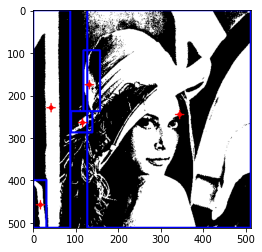

In [203]:
ufs = FindSet(bina)
set_table = AggregateSet(bina, ufs)
filt_set_table = FiltArea(set_table)
result = DrawBoundaryAndCentroid(bina, filt_set_table)

plt.imshow(result)
cv2.imwrite('boundary bina.bmp', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
cv2.imwrite('boundary bina.png', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))